# Notebook for Unsupervised ML: Clustering phases

Code inspired by L. Wang, Discovering Phase Transitions with Unsupervised Learning, Phys. Rev. B 94 (2016). https://doi.org/10.1103/PhysRevB.94.195105.

Code generated with assistance of ChatGPT (30 Sept 2025)

## Set up working tree and load packages

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import hdbscan
import pickle

# set seeds to make outputs reproducible
seed = 42
np.random.seed(seed)

## Mount and load data

In [20]:
N = 80
pkl_path = f"mc_samples_{N}.pickle"
with open(pkl_path, "rb") as f:
    data = pickle.load(f)           # dict  {temperature: [arrays]}

# ------------------------------------------------------------
# 2. build (14 temps *100 samples per temp) × (80*80) matrix + temperature vector
# ------------------------------------------------------------
temps          = sorted(data.keys())         # e.g. 1.6 … 2.9
samples_per_T  = 100
total_samples  = len(temps) * samples_per_T  # 1400
flat_size      = N * N                       # 6400

lattice_bank = np.empty((total_samples, flat_size), dtype=np.int8)
labels       = np.empty(total_samples,        dtype=np.float64)

row = 0
for T in temps:
    cfgs = data[T][:samples_per_T]           # first 100 configs at this T
    for cfg in cfgs:
        lattice_bank[row] = cfg.astype(np.int8)  # cfg already flattened
        labels[row]       = float(T)
        row += 1

print("lattice_bank shape:", lattice_bank.shape)   # (1400, 6400)
print("labels shape      :", labels.shape)         # (1400,)
print("Temperatures      :", temps)

lattice_bank shape: (1400, 6400)
labels shape      : (1400,)
Temperatures      : [1.6, 1.7000000000000002, 1.8000000000000003, 1.9000000000000004, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.600000000000001, 2.700000000000001, 2.800000000000001, 2.9000000000000012]


## Use ANN (AE) for dimensionality reduction

Saved: ising_AE_embedding_T_and_M.png


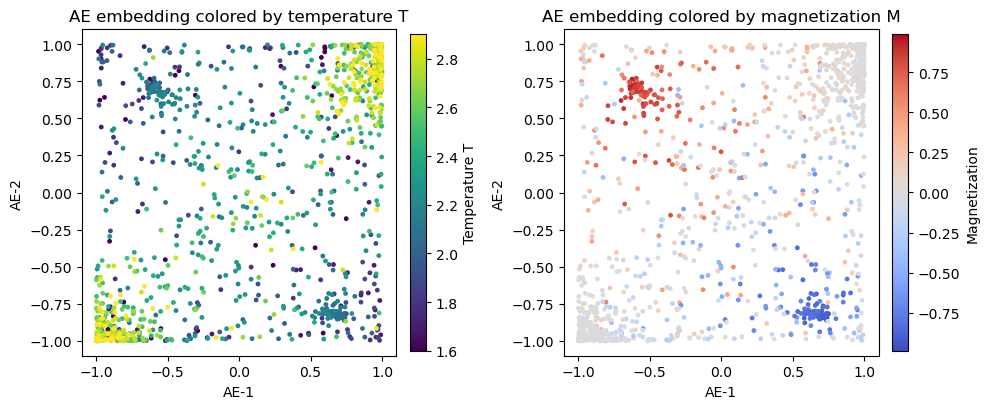

In [27]:
# --------------------- Autoencoder (ANN) ---------------------
# Assumes you already have: lattice_bank (n_samples x n_features), labels (temperatures)
# Produces a 2-D embedding via an MLP autoencoder and plots it colored by T and by magnetization M.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

mpl.rcParams['text.usetex'] = False

# ---------- Prepare data ----------
X = lattice_bank.astype(np.float32)  # (n_samples, 6400) for N=80
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

# ---------- Train a very simple symmetric AE with a 2-D bottleneck ----------
# Architecture:  input -> 512 -> 128 -> 2 -> 128 -> 512 -> output
ae = MLPRegressor(
    hidden_layer_sizes=(512, 128, 5, 128, 512),
    activation="tanh",            # stable small bottlenecks
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-5,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)
ae.fit(X_scaled, X_scaled)

# ---------- Forward to the bottleneck to get the 2-D embedding ----------
Ws = ae.coefs_
bs = ae.intercepts_

# tanh activation to match the model
def _tanh(z): 
    return np.tanh(z)

H1 = _tanh(X_scaled @ Ws[0] + bs[0])      # 512
H2 = _tanh(H1        @ Ws[1] + bs[1])     # 128
emb = _tanh(H2       @ Ws[2] + bs[2])     # 2-D bottleneck (embedding), shape (n_samples, 2)

# ---------- Compute magnetization per sample (mean spin), robust to {0,1} or {-1,1} ----------
spins = lattice_bank.astype(np.float32)
uvals = np.unique(spins)
if set(np.round(uvals).astype(int)).issubset({0,1}):
    spins = 2.0 * spins - 1.0   # map {0,1} -> {-1,1}
magnetization = spins.mean(axis=1)  # shape (n_samples,)

# --------------------- Plot embeddings ---------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
fig.subplots_adjust(wspace=0.20)

# (Left): colored by temperature
sc0 = axes[0].scatter(emb[:, 0], emb[:, 1], c=labels, cmap='viridis', s=6)
cbar0 = fig.colorbar(sc0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label('Temperature T')
axes[0].set_xlabel('AE-1'); axes[0].set_ylabel('AE-2')
axes[0].set_title('AE embedding colored by temperature T')

# (Right): colored by magnetization
sc1 = axes[1].scatter(emb[:, 0], emb[:, 1], c=magnetization, cmap='coolwarm', s=6)
cbar1 = fig.colorbar(sc1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label('Magnetization')
axes[1].set_xlabel('AE-1'); axes[1].set_ylabel('AE-2')
axes[1].set_title('AE embedding colored by magnetization M')

plt.tight_layout()
png_path = "ising_AE_embedding_T_and_M.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight")
print("Saved:", png_path)